# Healthcare Claims Case Study

## Business Problem Statement

Your company, XYZ Inc., processes insurance claims from various healthcare providers. Recently, the company has observed a significant increase in the processing time and cost associated with handling these claims.

As a newly hired data scientist, your task is to analyze the claims data to identify key factors contributing to delays and increased costs, detect patterns indicating potential inefficiencies or errors, and provide actionable recommendations to improve the overall claims processing workflow.

## Objectives

1. Identify Factors Influencing Processing Time and Cost
Determine which factors (e.g., claim amount, provider, diagnosis code, procedure code) are most strongly associated with longer processing times and higher costs.
2. Detect Patterns and Anomalies
Identify patterns that could indicate systematic issues, such as certain providers consistently submitting incorrect claims or specific diagnosis codes that are associated with higher denial rates.
3. Predict Processing Time and Cost using ML
Based on your data analysis and EDA, create a predictive model (use any algorithm of your choice) to predict processing time and processing cost. Also, show the driving factors for your predictions
4. Provide Actionable Recommendations
Based on your analysis, propose specific actions to streamline the claims processing workflow, reduce costs, and improve accuracy.

In [1]:
# Libraries:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNet
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Data Set:
df = pd.read_excel('Healthcare Claims Case Study - Data Science.xlsx', sheet_name = 'Dataset') 

In [3]:
df.sample(3)

,ClaimID,ProviderID,MemberID,ClaimAmount,ClaimDate,ServiceDate,DiagnosisCode,ProcedureCode,ClaimStatus,ProcessingTime,ProcessingCost,ProviderName
738,e174390f-2dec-4cf8-95ed-c5649d74fb96,a7537928-baab-4fb1-bc85-d4a858e7ce60,a9f4178d-d6e3-4b37-a412-37e7727e3208,797.62,2023-09-18,2022-07-18,uK392,EQK89,Denied,20,12.62,Harris-Robinson
983,8376add8-d8d3-473b-a861-1418ebd0a0fe,73f087af-5b9d-439a-aab3-615f1cc5f195,d24165ff-268b-438b-9675-cbfc16119354,2899.76,2024-05-27,2023-01-03,Nm584,kju55,Denied,2,161.05,"Ayala, Reed and Smith"
69,b09dcdbd-269b-4417-82b5-89222d4a9fc8,73f087af-5b9d-439a-aab3-615f1cc5f195,c0a52592-eebd-481b-99b9-66b121d276e3,951.24,2023-05-14,2022-10-28,fV680,PUn26,Approved,6,44.38,"Ayala, Reed and Smith"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ClaimID         1005 non-null   object        
 1   ProviderID      1005 non-null   object        
 2   MemberID        1005 non-null   object        
 3   ClaimAmount     995 non-null    float64       
 4   ClaimDate       1000 non-null   datetime64[ns]
 5   ServiceDate     1005 non-null   datetime64[ns]
 6   DiagnosisCode   1005 non-null   object        
 7   ProcedureCode   1005 non-null   object        
 8   ClaimStatus     1005 non-null   object        
 9   ProcessingTime  1005 non-null   int64         
 10  ProcessingCost  1005 non-null   float64       
 11  ProviderName    1005 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 94.3+ KB


In [5]:
df.describe()

,ClaimAmount,ClaimDate,ServiceDate,ProcessingTime,ProcessingCost
count,995.000000,1000,1005,1005.000000,1005.000000
mean,2478.426040,2023-09-07 10:24:57.600000256,2022-12-11 02:08:57.313432832,30.078607,106.532149
min,53.860000,2022-06-29 00:00:00,2022-06-11 00:00:00,1.000000,10.240000
25%,1235.485000,2023-05-10 00:00:00,2022-09-12 00:00:00,14.000000,59.500000
50%,2484.750000,2023-09-12 12:00:00,2022-12-13 00:00:00,30.000000,107.650000
75%,3698.945000,2024-01-25 00:00:00,2023-03-10 00:00:00,45.000000,155.110000
max,4996.940000,2024-06-09 00:00:00,2023-06-09 00:00:00,60.000000,199.910000
std,1438.282731,NaN,NaN,17.539846,55.503870


In [6]:
df = df.rename(columns = {'ClaimID': 'Claim_ID', 'ProviderID': 'Provider_ID',
                          'MemberID': 'Member_ID','ClaimAmount': 'Claim_Amount',
                          'ClaimDate': 'Claim_Date', 'ServiceDate': 'Service_Date', 'DiagnosisCode': 'Diagnosis_Code',
                          'ProcedureCode': 'Procedure_Code', 'ClaimStatus': 'Claim_Status', 'ProcessingTime': 'Processing_Time',
                          'ProcessingCost': 'Processing_Cost', 'ProviderName': 'Provider_Name'})

df.columns = df.columns.str.lower()

In [7]:
df.columns

Index(['claim_id', 'provider_id', 'member_id', 'claim_amount', 'claim_date',
       'service_date', 'diagnosis_code', 'procedure_code', 'claim_status',
       'processing_time', 'processing_cost', 'provider_name'],
      dtype='object')

In [8]:
print(f'Duplicated data:', df.duplicated().sum())

df[df.duplicated()]

Duplicated data: 5


,claim_id,provider_id,member_id,claim_amount,claim_date,service_date,diagnosis_code,procedure_code,claim_status,processing_time,processing_cost,provider_name
1000,eb72ea36-330f-4454-a31f-72d7c55e2cfc,73f087af-5b9d-439a-aab3-615f1cc5f195,10982077-0161-4861-a919-37450730712e,4351.24,2024-02-04,2022-06-17,pV503,SCn90,Denied,15,175.49,"Ayala, Reed and Smith"
1001,819ba17d-e7c2-42cc-b316-25fc725db060,363ee786-8c4e-43fe-98b0-63abb11409e3,02d2b04c-0a94-4dc3-a074-32606f002002,3937.72,2024-05-30,2023-03-14,bV215,yup83,Approved,46,93.80,"Allison, Brown and Jordan"
1002,0f6094e2-ea48-4735-b794-dac22d8961bb,806ad6cf-5486-4702-bce8-938ebabe72b3,b09ea12b-30fd-48d7-959f-e65d04a75891,1311.61,2023-02-03,2023-01-12,kg582,gqF91,Pending,24,106.40,"Lewis, Compton and Jackson"
1003,acf13a52-01b5-4ec7-bb3b-7e33122d10db,a7537928-baab-4fb1-bc85-d4a858e7ce60,37613a67-0f7b-4504-b48f-b1b8c94f8f67,2901.85,2023-10-08,2023-01-11,qW627,IPL92,Pending,60,130.74,Harris-Robinson
1004,582f19d6-cb6a-4fcc-a8d8-590cb78ad13a,363ee786-8c4e-43fe-98b0-63abb11409e3,8b86be16-091c-419f-aba9-b46046e3b258,4233.07,2023-07-07,2023-04-18,TX088,BPo77,Approved,31,69.70,"Allison, Brown and Jordan"


In [9]:
df = df.drop_duplicates().reset_index(drop = True)

print(f'Duplicated data:', df.duplicated().sum())

Duplicated data: 0


In [10]:
print(df.isna().sum())
print()
print(100 * df.isna().sum() / df.shape[0])

claim_id            0
provider_id         0
member_id           0
claim_amount       10
claim_date          5
service_date        0
diagnosis_code      0
procedure_code      0
claim_status        0
processing_time     0
processing_cost     0
provider_name       0
dtype: int64

claim_id           0.0
provider_id        0.0
member_id          0.0
claim_amount       1.0
claim_date         0.5
service_date       0.0
diagnosis_code     0.0
procedure_code     0.0
claim_status       0.0
processing_time    0.0
processing_cost    0.0
provider_name      0.0
dtype: float64


### Observations: 

- The dataset has all the right types of values, there is no need to make changes.
- I did some changes on the column's names in order to keep good practices. 
- The dataset had duplicated data, only 5 values, so I proceed to erase them.
- The dataset has missing values in 2 different columns, 10 in the claim_amount column, and 5 in the claim_date one. They only represent 1% and 0.5% of the data respectively, it can be erased, but, in order to keep as much data as posible, **I'll proceed to impute the data from claim_amount with the average of the claim's amounts and erase the incomplete data that does not have a clear claim date.**


In [11]:
# Imputation of missing data: 

ca_mean = df['claim_amount'].mean().round(2)

print(ca_mean)

df['claim_amount'] = df['claim_amount'].fillna(ca_mean)

2474.04


In [12]:
# Erase missing data: 

df = df.dropna(subset ='claim_date')

In [13]:
print(df.isna().sum())

claim_id           0
provider_id        0
member_id          0
claim_amount       0
claim_date         0
service_date       0
diagnosis_code     0
procedure_code     0
claim_status       0
processing_time    0
processing_cost    0
provider_name      0
dtype: int64


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 0 to 999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   claim_id         995 non-null    object        
 1   provider_id      995 non-null    object        
 2   member_id        995 non-null    object        
 3   claim_amount     995 non-null    float64       
 4   claim_date       995 non-null    datetime64[ns]
 5   service_date     995 non-null    datetime64[ns]
 6   diagnosis_code   995 non-null    object        
 7   procedure_code   995 non-null    object        
 8   claim_status     995 non-null    object        
 9   processing_time  995 non-null    int64         
 10  processing_cost  995 non-null    float64       
 11  provider_name    995 non-null    object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 101.1+ KB


In [15]:
def range_of_cost(processing_cost):
    
    if processing_cost <= 49:
        return 'less than 50 dollars'
    elif processing_cost <= 100:
        return 'between 50 and a 100 dollars'
    elif processing_cost <= 150:
        return 'more than a 100, less than 150'
    else:
        return 'more than 150 dollars'

df['range_of_cost'] = df['processing_cost'].apply(range_of_cost)

In [16]:
def process_duration(processing_time):
    
    if processing_time <= 7:
        return 'one week'
    elif processing_time <= 15:
        return 'two weeks'
    elif processing_time <= 31:
        return 'month'
    else:
        return 'more than a month'

df['process_duration'] = df['processing_time'].apply(process_duration)

## EDA:

In [17]:
# Processing cost and claim amount

pc_vs_ca = df.groupby('range_of_cost')['claim_amount'].count().reset_index().sort_values(by = 'claim_amount', ascending = False)

pc_vs_ca.head()

,range_of_cost,claim_amount
2,more than 150 dollars,282
0,between 50 and a 100 dollars,254
3,"more than a 100, less than 150",249
1,less than 50 dollars,210


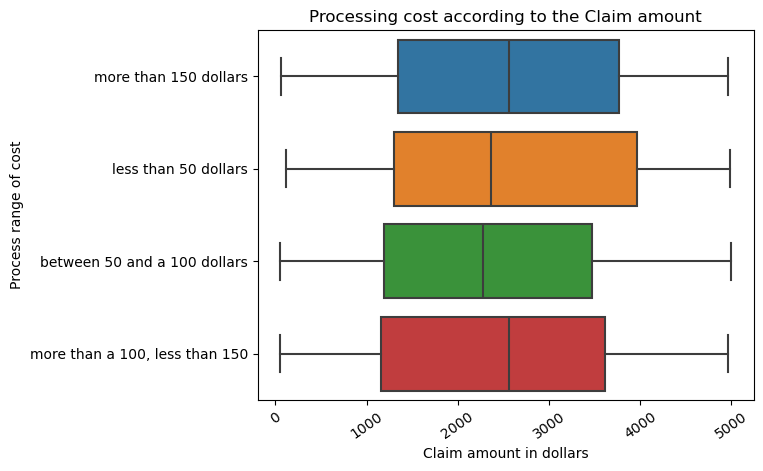

In [18]:
# Processing cost and claim amount

sns.boxplot(data = df,
             x = 'claim_amount',
             y = 'range_of_cost')

plt.title('Processing cost according to the Claim amount')
plt.xlabel('Claim amount in dollars')
plt.ylabel('Process range of cost')
plt.xticks(rotation = 35)
plt.show()

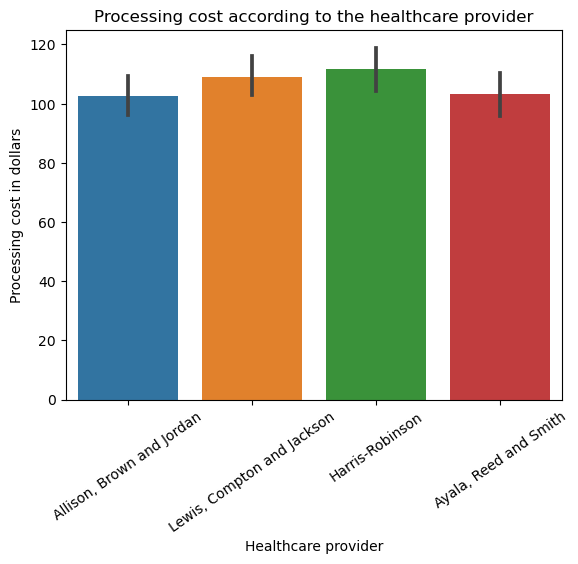

In [19]:
# Processing cost and Provider name

sns.barplot(data = df,
             x = 'provider_name',
             y = 'processing_cost')

plt.title('Processing cost according to the healthcare provider')
plt.xlabel('Healthcare provider')
plt.ylabel('Processing cost in dollars')
plt.xticks(rotation = 35)
plt.show()

In [20]:
costs_by_providers = df.groupby('provider_name')['processing_cost'].sum().reset_index().sort_values(by = 'processing_cost', ascending = False)

costs_by_providers.head()

,provider_name,processing_cost
3,"Lewis, Compton and Jackson",29802.56
0,"Allison, Brown and Jordan",27355.30
2,Harris-Robinson,25919.10
1,"Ayala, Reed and Smith",23005.78


In [21]:
df['procedure_code'] = df['procedure_code'].astype('str')

print(df.dtypes)

claim_id                    object
provider_id                 object
member_id                   object
claim_amount               float64
claim_date          datetime64[ns]
service_date        datetime64[ns]
diagnosis_code              object
procedure_code              object
claim_status                object
processing_time              int64
processing_cost            float64
provider_name               object
range_of_cost               object
process_duration            object
dtype: object


[False]


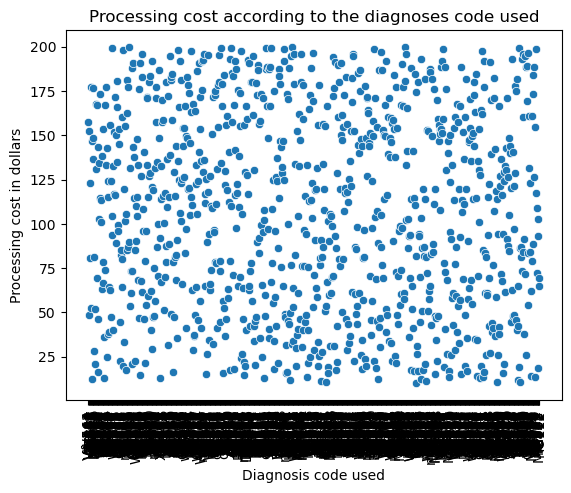

In [22]:
# Processing cost and Diagnosis code

print(df.duplicated(subset = 'diagnosis_code').unique())

sns.scatterplot(data = df,
             x = 'diagnosis_code',
             y = 'processing_cost')

plt.title('Processing cost according to the diagnoses code used')
plt.xlabel('Diagnosis code used')
plt.ylabel('Processing cost in dollars')
plt.xticks(rotation = 90)
plt.show()

[False]


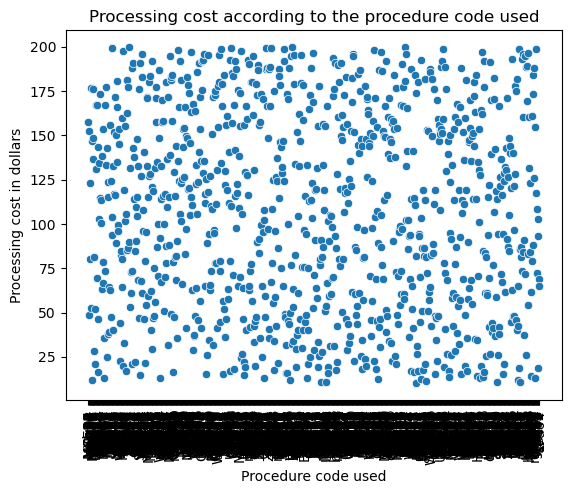

In [23]:
# Procedure code and processing cost

print(df.duplicated(subset = 'procedure_code').unique())

sns.scatterplot(data = df,
             x = 'procedure_code',
             y = 'processing_cost')

plt.title('Processing cost according to the procedure code used')
plt.xlabel('Procedure code used')
plt.ylabel('Processing cost in dollars')
plt.xticks(rotation = 90)
plt.show()

### Observations: 

- In 29% of the cases, the claims costs more than 150 dollars while processing; a 26% of the claims costs more than a 100 dollars, but less than $150, other 26% costs between 50 and 100 dollars, and a 21% costs less than 50%.
- Most of the claims that are made are for more than 2000 dollars. 581 claims for more than 2000, 414 for less (10 unknown).
- There are not repeated codes in the procedure and diagnoses label, that means it couldn't be a pattern between that data and the processing cost of the claims. There is no correlation between that data.

**_____________________________________________________**

In [24]:
pt_vs_ca = df.groupby('process_duration')['claim_amount'].count().reset_index().sort_values(by = 'claim_amount', ascending = False)

pt_vs_ca.head()

,process_duration,claim_amount
1,more than a month,475
0,month,254
3,two weeks,139
2,one week,127


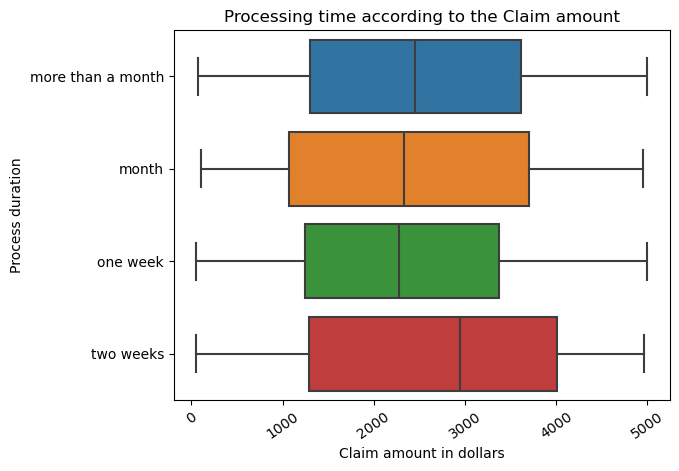

In [25]:
# Processing time and claim amount:

sns.boxplot(data = df,
             x = 'claim_amount',
             y = 'process_duration')

plt.title('Processing time according to the Claim amount')
plt.xlabel('Claim amount in dollars')
plt.ylabel('Process duration')
plt.xticks(rotation = 35)
plt.show()

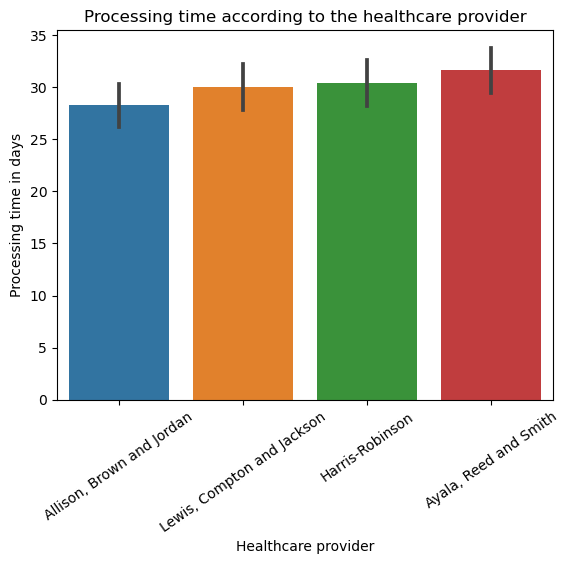

In [26]:
# Processing time and Provider name:

sns.barplot(data = df,
             x = 'provider_name',
             y = 'processing_time')

plt.title('Processing time according to the healthcare provider')
plt.xlabel('Healthcare provider')
plt.ylabel('Processing time in days')
plt.xticks(rotation = 35)
plt.show()

In [27]:
average_time_provider = df.groupby('provider_name')['processing_time'].mean().reset_index().sort_values(by = 'processing_time', ascending = False)

average_time_provider.head()

,provider_name,processing_time
1,"Ayala, Reed and Smith",31.681614
2,Harris-Robinson,30.448276
3,"Lewis, Compton and Jackson",30.047619
0,"Allison, Brown and Jordan",28.303371


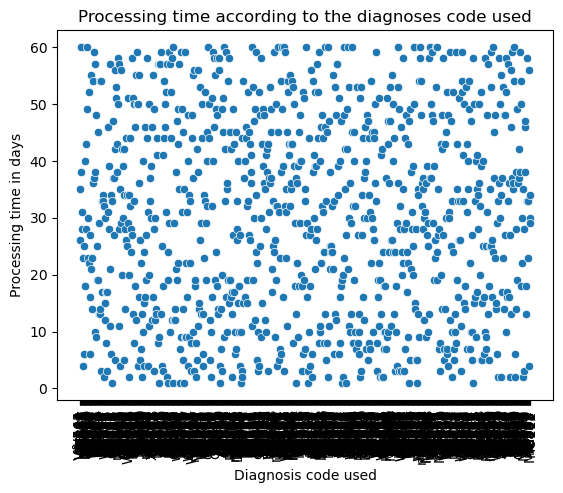

In [28]:
# Processing time and Diagnosis code

sns.scatterplot(data = df,
             x = 'diagnosis_code',
             y = 'processing_time')

plt.title('Processing time according to the diagnoses code used')
plt.xlabel('Diagnosis code used')
plt.ylabel('Processing time in days')
plt.xticks(rotation = 90)
plt.show()

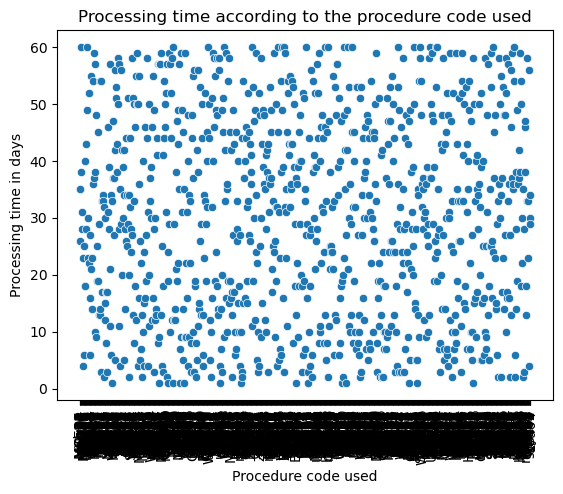

In [29]:
# Procedure code and processing time

sns.scatterplot(data = df,
             x = 'procedure_code',
             y = 'processing_time')

plt.title('Processing time according to the procedure code used')
plt.xlabel('Procedure code used')
plt.ylabel('Processing time in days')
plt.xticks(rotation = 90)
plt.show()

### Observations: 

- Almost half of the claims (49%), took more than a month to be processed. 26% took a month, 14% a two weeks period to be processed, and only 13% were processed within a week.
- 'Ayala, Reed and Smith' claims usually take more days to be processed (31 days average), then the ones from  'Harris-Robinson' (30 days), followed by 'Lewis, Compton and Jackson'(30 days), and finally 'Allison, Brown and Jordan' (28 days).
- There are not repeated codes in the procedure and diagnoses label, that means it couldn't be a pattern between that data and the processing time of the claims. There is no correlation between that data.


**_____________________________________________________**

## Finding trends:

In [30]:
# Creation of new columns:

df['claim_year'] = df['claim_date'].dt.year

df['claim_month'] = df['claim_date'].dt.month

df['service_year'] = df['service_date'].dt.year

df['service_month'] = df['service_date'].dt.month

/Users/PaulaTrujilloSanchez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/PaulaTrujilloSanchez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


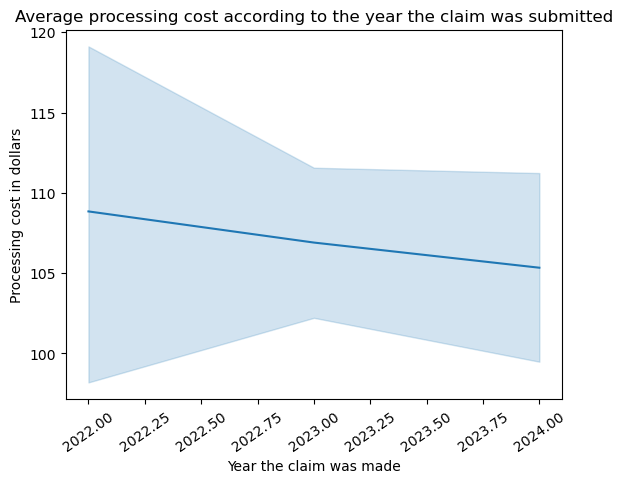

In [31]:
# Processing cost and Year of the claim:

sns.lineplot(data = df,
             x = 'claim_year',
             y = 'processing_cost')

plt.title('Average processing cost according to the year the claim was submitted')
plt.xlabel('Year the claim was made')
plt.ylabel('Processing cost in dollars')
plt.xticks(rotation = 35)
plt.show()

In [32]:
average_pc_by_year = df.groupby('claim_year')['processing_cost'].mean().reset_index().sort_values(by = 'processing_cost', ascending = False)

average_pc_by_year

,claim_year,processing_cost
0,2022,108.841915
1,2023,106.901658
2,2024,105.335235


In [33]:
pc_by_year = df.groupby('claim_year')['processing_cost'].sum().reset_index().sort_values(by = 'processing_cost', ascending = False)

pc_by_year

,claim_year,processing_cost
1,2023,64461.70
2,2024,31389.90
0,2022,10231.14


/Users/PaulaTrujilloSanchez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/PaulaTrujilloSanchez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


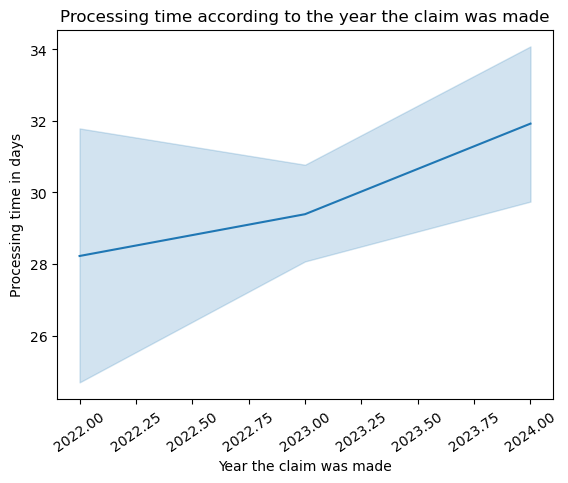

In [34]:
# Processing time and Year of the claim:

sns.lineplot(data = df,
             x = 'claim_year',
             y = 'processing_time')

plt.title('Processing time according to the year the claim was made')
plt.xlabel('Year the claim was made')
plt.ylabel('Processing time in days')
plt.xticks(rotation = 35)
plt.show()

In [35]:
claims_by_year = df.groupby('claim_year')['claim_id'].count().reset_index().sort_values(by = 'claim_year', ascending = False)

claims_by_year

,claim_year,claim_id
2,2024,298
1,2023,603
0,2022,94


In [36]:
claims_by_year_pt = df.groupby('claim_year')['processing_time'].mean().round(2).reset_index().sort_values(by = 'processing_time', ascending = False)

claims_by_year_pt

,claim_year,processing_time
2,2024,31.92
1,2023,29.39
0,2022,28.22


In [37]:
claims_by_month_year = df.groupby(['claim_month', 'claim_year'])['claim_id'].count().reset_index().sort_values(by = 'claim_id', ascending = False)

claims_by_month_year

,claim_month,claim_year,claim_id
18,9,2023,68
7,4,2024,65
16,8,2023,64
9,5,2024,63
1,1,2024,61
24,12,2023,57
11,6,2023,57
14,7,2023,56
20,10,2023,55
22,11,2023,52


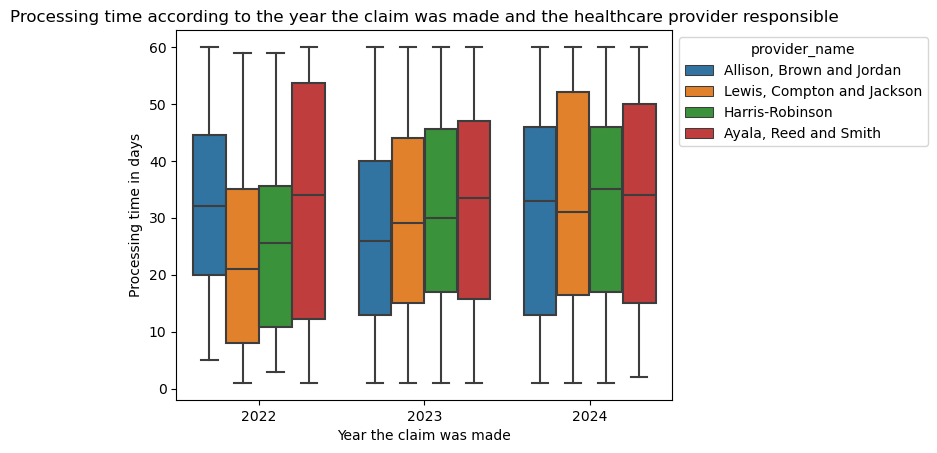

In [38]:
graphic_1 = sns.boxplot(data = df,
             x = 'claim_year',
             y = 'processing_time',
             hue = 'provider_name')

plt.title('Processing time according to the year the claim was made and the healthcare provider responsible')
plt.xlabel('Year the claim was made')
plt.ylabel('Processing time in days')
sns.move_legend(graphic_1, 'upper left', bbox_to_anchor = (1, 1))
plt.show()

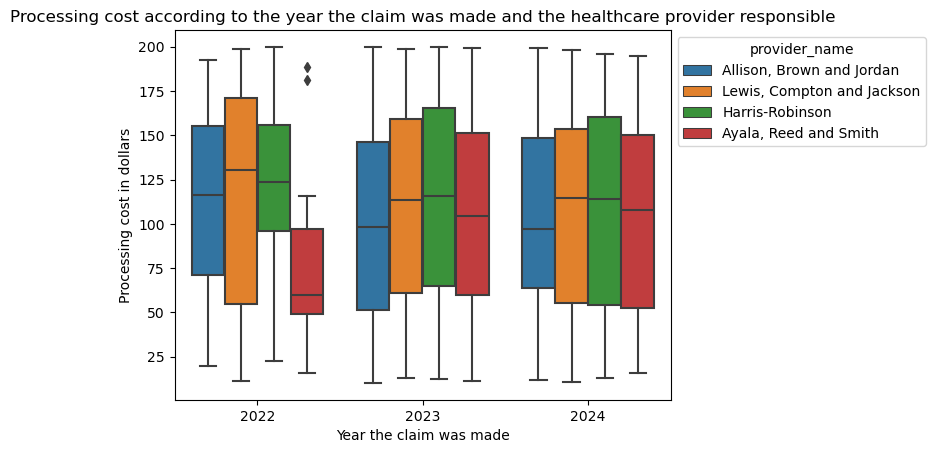

In [39]:
graphic_2 = sns.boxplot(data = df,
             x = 'claim_year',
             y = 'processing_cost',
             hue = 'provider_name')

plt.title('Processing cost according to the year the claim was made and the healthcare provider responsible')
plt.xlabel('Year the claim was made')
plt.ylabel('Processing cost in dollars')
sns.move_legend(graphic_2, 'upper left', bbox_to_anchor = (1, 1))
plt.show()

In [40]:
claims_by_provider = df.groupby('provider_name')['claim_id'].count().reset_index().sort_values(by = 'claim_id', ascending = False)

claims_by_provider.head()

,provider_name,claim_id
3,"Lewis, Compton and Jackson",273
0,"Allison, Brown and Jordan",267
2,Harris-Robinson,232
1,"Ayala, Reed and Smith",223


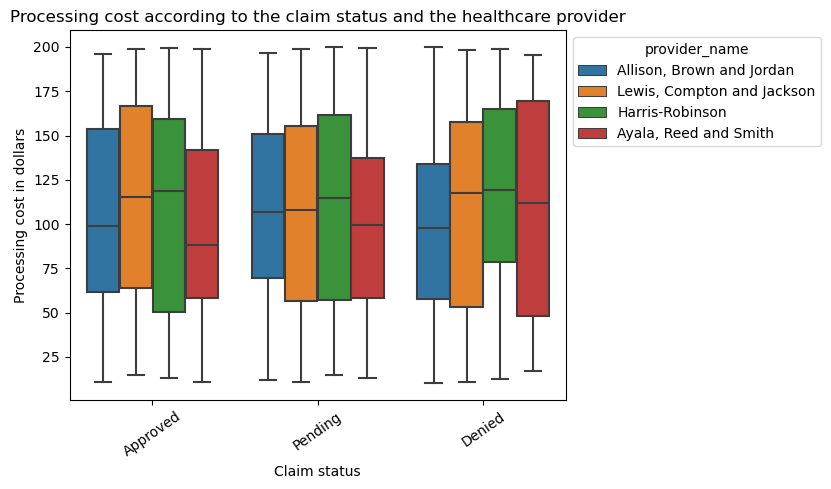

In [41]:
# Processing cost and claim status

graphic_3 = sns.boxplot(data = df,
             x = 'claim_status',
             y = 'processing_cost',
             hue = 'provider_name')

plt.title('Processing cost according to the claim status and the healthcare provider')
plt.xlabel('Claim status')
plt.ylabel('Processing cost in dollars')
plt.xticks(rotation = 35)
sns.move_legend(graphic_3, 'upper left', bbox_to_anchor = (1, 1))
plt.show()

/Users/PaulaTrujilloSanchez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/PaulaTrujilloSanchez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/PaulaTrujilloSanchez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/PaulaTrujilloSanchez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

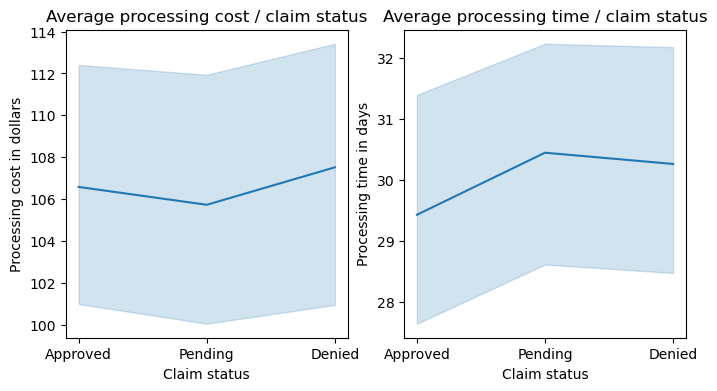

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

sns.lineplot(data = df,
            ax = ax1, 
            x = 'claim_status',
            y = 'processing_cost')

plt.subplot(1, 2, 1)
plt.title('Average processing cost / claim status')
plt.xlabel('Claim status')
plt.ylabel('Processing cost in dollars')

sns.lineplot(data = df,
            ax = ax2, 
            x = 'claim_status', 
            y = 'processing_time')

plt.subplot(1, 2, 2)
plt.title('Average processing time / claim status')
plt.xlabel('Claim status')
plt.ylabel('Processing time in days')

plt.show()


In [43]:
claims_status_costs = df.groupby('claim_status')['processing_cost'].mean().reset_index().sort_values(by = 'processing_cost', ascending = False)

claims_status_costs.head()

,claim_status,processing_cost
1,Denied,107.517825
0,Approved,106.579006
2,Pending,105.727702


In [44]:
claims_status_time = df.groupby('claim_status')['processing_time'].mean().reset_index().sort_values(by = 'processing_time', ascending = False)

claims_status_time.head()

,claim_status,processing_time
2,Pending,30.450311
1,Denied,30.265861
0,Approved,29.432749


## Observations: 
- 'Harris-Robinson' tends to have the most expensive processing costs; followed by 'Lewis, Compton and Jackson', then 'Ayala, Reed and Smith' and finally, 'Allison, Brown and Jordan'. Nevertheless, 'Harris-Robinson' is one the providers with less claims, costing the system:	25919.10, 'Lewis, Compton and Jackson' has had more claims than the others, costing the system 29802.56 dollars. On the other hand, 'Allison, Brown and Jordan' is the second provider with more claims, with a cost of processing of 27355.30 dollars. 'Ayala, Reed and Smith' is the provider with fewer claims and with a cost of processing of 23005.78 dollars, being the one that costs the less to the system. 
- The processing cost has lower progressively from 2022 to 2024, it started as 108.84 dollars, then in 2023 was 106.9 and finally, in 2024 has descended to 105.55 dollars.
- 2023 has been the year with more claims submitted, with 603 claims, its processing costs were $64461.70.
- There are no coincidences among the years regarding the month and the number of claims.
- According to the Graphic 1: 'Processing time according to the year the claim was made and the healthcare provider responsible', through the years, no matter the healthcare provider, the processing time gain some stability and 75% of the claims could be processed before 45 days. Then, in 2024, 'Lewis, Compton and Jackson' and 'Ayala, Reed and Smith' took a little bit longer. 
- In average, it is higher the cost of processing when a claim is denied, it also takes more time than other claims (but not as much as when the status is pending).

## ML:

In [45]:
# Elimination of the columns that do not contribute to the Machine Learning model:

df_ml = df.drop(['claim_id', 'provider_id', 'member_id', 'claim_date', 'service_date',
                 'diagnosis_code', 'procedure_code', 'process_duration', 'range_of_cost',
                 'claim_month', 'service_month'], axis = 1)

In [46]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   claim_amount     995 non-null    float64
 1   claim_status     995 non-null    object 
 2   processing_time  995 non-null    int64  
 3   processing_cost  995 non-null    float64
 4   provider_name    995 non-null    object 
 5   claim_year       995 non-null    int32  
 6   service_year     995 non-null    int32  
dtypes: float64(2), int32(2), int64(1), object(2)
memory usage: 54.4+ KB


In [47]:
df_ml.head(2)

,claim_amount,claim_status,processing_time,processing_cost,provider_name,claim_year,service_year
0,4775.45,Approved,35,157.61,"Allison, Brown and Jordan",2024,2023
1,3197.35,Pending,35,152.29,"Lewis, Compton and Jackson",2022,2022


In [48]:
#Application of the One Hot method to take advantage of non-numeric columns.

df_ml = pd.get_dummies(df_ml, dtype = int, drop_first = False)

print(df_ml.shape)

(995, 12)


In [49]:
df_ml.head(2)

,claim_amount,processing_time,processing_cost,claim_year,service_year,claim_status_Approved,claim_status_Denied,claim_status_Pending,"provider_name_Allison, Brown and Jordan","provider_name_Ayala, Reed and Smith",provider_name_Harris-Robinson,"provider_name_Lewis, Compton and Jackson"
0,4775.45,35,157.61,2024,2023,1,0,0,1,0,0,0
1,3197.35,35,152.29,2022,2022,0,0,1,0,0,0,1


In [50]:
print(df_ml.columns)

Index(['claim_amount', 'processing_time', 'processing_cost', 'claim_year',
       'service_year', 'claim_status_Approved', 'claim_status_Denied',
       'claim_status_Pending', 'provider_name_Allison, Brown and Jordan',
       'provider_name_Ayala, Reed and Smith', 'provider_name_Harris-Robinson',
       'provider_name_Lewis, Compton and Jackson'],
      dtype='object')


In [51]:
df_ml_target = df_ml.drop(['claim_amount', 'claim_year', 'service_year', 'claim_status_Denied', 
                           'claim_status_Pending','provider_name_Ayala, Reed and Smith', 
                           'provider_name_Harris-Robinson', 'provider_name_Lewis, Compton and Jackson'], axis = 1)

df_ml_features = df_ml.drop(['processing_time', 'processing_cost'], axis = 1)     

X, y = df_ml_features, df_ml_target

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size = 0.5, random_state = 30)

In [53]:
print('X_train dimension:', X_train.shape)
print('X_test dimension:', X_test.shape)
print('X_valid dimension:', X_valid.shape)
print('y_train dimension:', y_train.shape)
print('y_test dimension:', y_test.shape)
print('y_valid dimension:', y_valid.shape)

X_train dimension: (796, 10)
X_test dimension: (99, 10)
X_valid dimension: (100, 10)
y_train dimension: (796, 4)
y_test dimension: (99, 4)
y_valid dimension: (100, 4)


## ML Models: 

In [54]:
# Model 1: Decision Tree Regressor

model_dtr = DecisionTreeRegressor(max_depth = 5, random_state = 30) 

model_dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=30)

In [55]:
# Model 2: Random Forest Regressor

model_rfr = RandomForestRegressor(random_state = 30, n_estimators = 100, max_depth = 30)

model_rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, random_state=30)

In [56]:
# Model 3: Multi-target Regression

multioutput_model = MultiOutputRegressor(ElasticNet(alpha = 0.5, l1_ratio = 0.5), n_jobs = 5)

multioutput_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=ElasticNet(alpha=0.5), n_jobs=5)

In [57]:
# Make predictions
tree_pred = model_dtr.predict(X_valid)
forest_pred = model_rfr.predict(X_valid)
multioutput_pred = multioutput_model.predict(X_valid)
 
# Calculate performance metrics for multioutput model
multioutput_mse = mean_squared_error(y_valid, multioutput_pred).round(3)
multioutput_mae = mean_absolute_error(y_valid, multioutput_pred).round(3)
 
# Calculate performance metrics for decision tree model
tree_mse = mean_squared_error(y_valid, tree_pred).round(3)
tree_mae = mean_absolute_error(y_valid, tree_pred).round(3)

# Calculate performance metrics for random forest model
forest_mse = mean_squared_error(y_valid, forest_pred).round(3)
forest_mae = mean_absolute_error(y_valid, forest_pred).round(3)

# Print the performance metrics

print("Decision Tree Model - Mean Squared Error:", tree_mse)
print("Decision Tree Model - Mean Absolute Error:", tree_mae)
print()
print("Random Forest Model - Mean Squared Error:", forest_mse)
print("Random Forest Model - Mean Absolute Error:", forest_mae)
print()
print("Multioutput Model - Mean Squared Error:", multioutput_mse)
print("Multioutput Model - Mean Absolute Error:", multioutput_mae)

Decision Tree Model - Mean Squared Error: 789.902
Decision Tree Model - Mean Absolute Error: 15.58

Random Forest Model - Mean Squared Error: 720.616
Random Forest Model - Mean Absolute Error: 14.628

Multioutput Model - Mean Squared Error: 808.675
Multioutput Model - Mean Absolute Error: 15.885


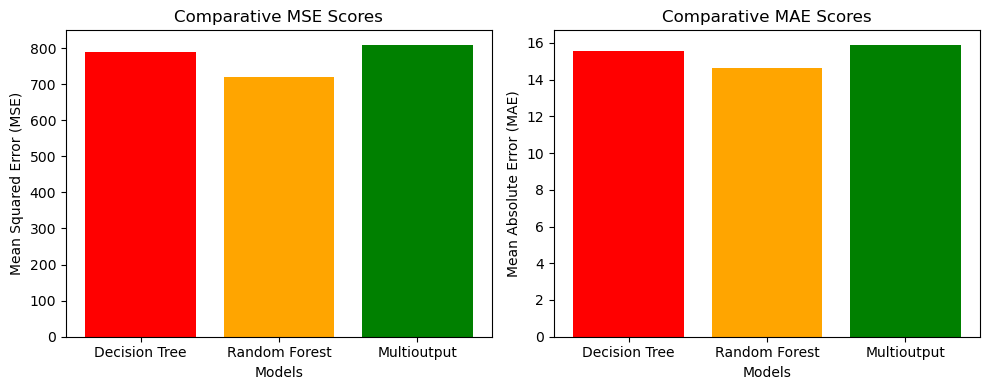

In [58]:
# Comparative visualization

plt.figure(figsize=(10, 4))
models = ['Decision Tree', 'Random Forest', 'Multioutput']
mse_scores = [tree_mse, forest_mse, multioutput_mse]
mae_scores = [tree_mae, forest_mae, multioutput_mae]
 
# Plot Mean Squared Error (MSE)
plt.subplot(1, 2, 1)
plt.bar(models, mse_scores, color=['red', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparative MSE Scores')

# Plot R-squared Score (R2)
plt.subplot(1, 2, 2)
plt.bar(models, mae_scores, color=['red', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparative MAE Scores')

plt.tight_layout()
plt.show()


## Conclusions:

1. Data Integrity and Preparation:

- The dataset is largely clean and appropriately structured. Minor adjustments were made, including renaming columns for consistency and handling missing values through a mix of imputation and deletion.
- Duplicates, though minimal, were removed to ensure data accuracy.

2. Processing Time:

- Almost half (49%) of claims take more than a month to process, with some healthcare providers averaging over 30 days.
Over time, processing time has stabilized, with 75% of claims being processed within 45 days. However, certain providers in 2024 experienced delays.

3. Cost Analysis:

- Processing costs have declined steadily from 108.84 dollars in 2022 to $105.55 in 2024, reflecting improved efficiency.
- Claims with denied statuses are more expensive to process and take longer, though not as much as pending claims.
- 'Harris-Robinson' incurs the highest cost per claim despite having fewer claims, while 'Ayala, Reed and Smith' is the least costly.

4. Claims Volume:

- 2023 saw the highest volume of claims, peaking at 603, with corresponding processing costs of $64,461.70.
- Monthly claims volumes show no consistent trends across years.

5. Patterns and Correlations:

- No clear patterns were identified between procedure/diagnosis codes and processing times.

## Recommendations and Actions:
To streamline the claims processing workflow, reduce costs, and improve accuracy, I would recommend the following actions:

1. Enhance Automation in Claims Processing:

- Implement machine learning models to predict processing time and flag claims likely to face delays or denials.
- Automate repetitive tasks like initial validation of claim details to reduce processing time further.

2. Focus on High-Cost Providers:

- Investigate why 'Harris-Robinson' has a high processing cost despite fewer claims. Negotiate contracts or redesign processes to minimize costs.
- Leverage insights from 'Ayala, Reed and Smith,' the least costly provider, to identify and replicate best practices across other providers.

3. Optimize Processing Time:

- Prioritize reducing the number of claims taking over a month to process. Establish benchmarks for each provider to ensure most of the claims are processed within 30 days.
- Address the slight delays observed in 2024 for 'Lewis, Compton and Jackson' and 'Ayala, Reed and Smith.'

4. Improve Accuracy for Costly Claims:

- Develop targeted interventions for denied claims, which cost more to process. For example, introduce a pre-check system to ensure claim accuracy and completeness before submission.

5. Monitor and Adjust Policies:

- Regularly review and adjust claims policies based on data-driven insights to ensure processing remains efficient and costs continue to decline.


